# CityLearn MARLISA 2022

```
Author: Chia E Tungom
Email: bamtungom@protonmail.com
Date: Aug-11-2022
```

In this Notebook we outline how the Multiagent Reinforcement Learning Algorithm MARLISA can be modified for the 2022 CityLearn Challenge.
For details on how MARLISA works, refer to the [study]() and for the orignal implementation refer to the [CityLearn git repository](https://github.com/intelligent-environments-lab/CityLearn/blob/master/agents/marlisa.py).

A brief of what the algorithm aims to achieve is a follows 
1. Implement a Multi-agent version of Soft-Actor Critic (SAC) algorithm
    - Design a reward function with individual and collective goals
    - Agents share information amongs each other using a leader-follower scheme
        - Each building has it's own RL agent
2. Use the algorithm to
    - Plan and Control energy storage of a diverse set of buildings
    - Aim to reshape the aggregated curve of electricity demand
    - Decide how much heating and cooling is stored or released at any time
3. Measure performance on the following metric
    - Annual net electricity consumption in the district
    - Average daily peak demand
    - Annual peak demand 
    - Ramping 

Unlike the CityLearn environment where MARLISA was implemented in, the 2022 CityLearn Challenge environment has different environmnet features and optimization objective. 
In this Notebook we aim to show how MARLISA can be adapted to the 2022 CityLearn Challenge. We do so by doing the following 
1. Setting Up the CityLearn 2022 Environment
2. Getting Building information (should be MARLISA compatible)
3. Some Data Overview
4. Generate Building State Actions requirements
5. Outline Modifications of MARLISA code
6. Run `MARLISA2022`

__Note:__ I only aim to make it easier for those who want to get started with MARL(ISA)

To Run this Notebook, you will need to have the started git repo with the following folder
- Get the MARLISA python file from the [intelligent-environments-lab](https://github.com/intelligent-environments-lab/CityLearn/blob/master/agents/marlisa.py) git hub repo and place in the agents folder 
- Get the common folder from the [intelligent-environments-lab](https://github.com/intelligent-environments-lab/CityLearn/tree/master/common) and place in the root folder of ur starter git folder
- Place this Notebook in the root folder as well
- __YOU ARE GOOD TO GO !!!!__

__This Notebook was made while listening to [MONALISA](https://www.youtube.com/watch?v=to8nQNGarRw). Enjoy!!! __

__Lets Gooooooooooo!!!__

## 1. Load Environment 

We beginning by setting Up our RL environment for CityLearn2022. Some of the code in this section  was  taken from the local evaluation python file in the starter kit repo

In [1]:
%matplotlib notebook


In [ ]:
import citylearn

In [ ]:
from citylearn import agents

In [ ]:
# import citylearn
# !pip3 install tqdm
!pip3 install pyqt5

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('TkAgg')

from pathlib import Path
from citylearn.agents.marlisa import MARLISA
import numpy as np
from tqdm import tqdm
import time
from citylearn.citylearn import CityLearnEnv


C:\Users\srava\synaptik\SynaptikApp\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Custom configure enviroment 
class Constants:
    episodes = 3
    schema_path = 'citylearn_challenge_2022_phase_1'

def action_space_to_dict(aspace):
    """ Only for box space """
    return { "high": aspace.high,
             "low": aspace.low,
             "shape": aspace.shape,
             "dtype": str(aspace.dtype)
    }

def env_reset(env):
    observations = env.reset()
    action_space = env.action_space
    observation_space = env.observation_space
    building_info = env.get_building_information()
    building_info = list(building_info.values())
    action_space_dicts = [action_space_to_dict(asp) for asp in action_space]
    observation_space_dicts = [action_space_to_dict(osp) for osp in observation_space]
    obs_dict = {"action_space": action_space_dicts,
                "observation_space": observation_space_dicts,
                "building_info": building_info,
                "observation": observations }
    return obs_dict

env = CityLearnEnv(schema=Constants.schema_path)

In [4]:
import IPython.display
import PIL.Image

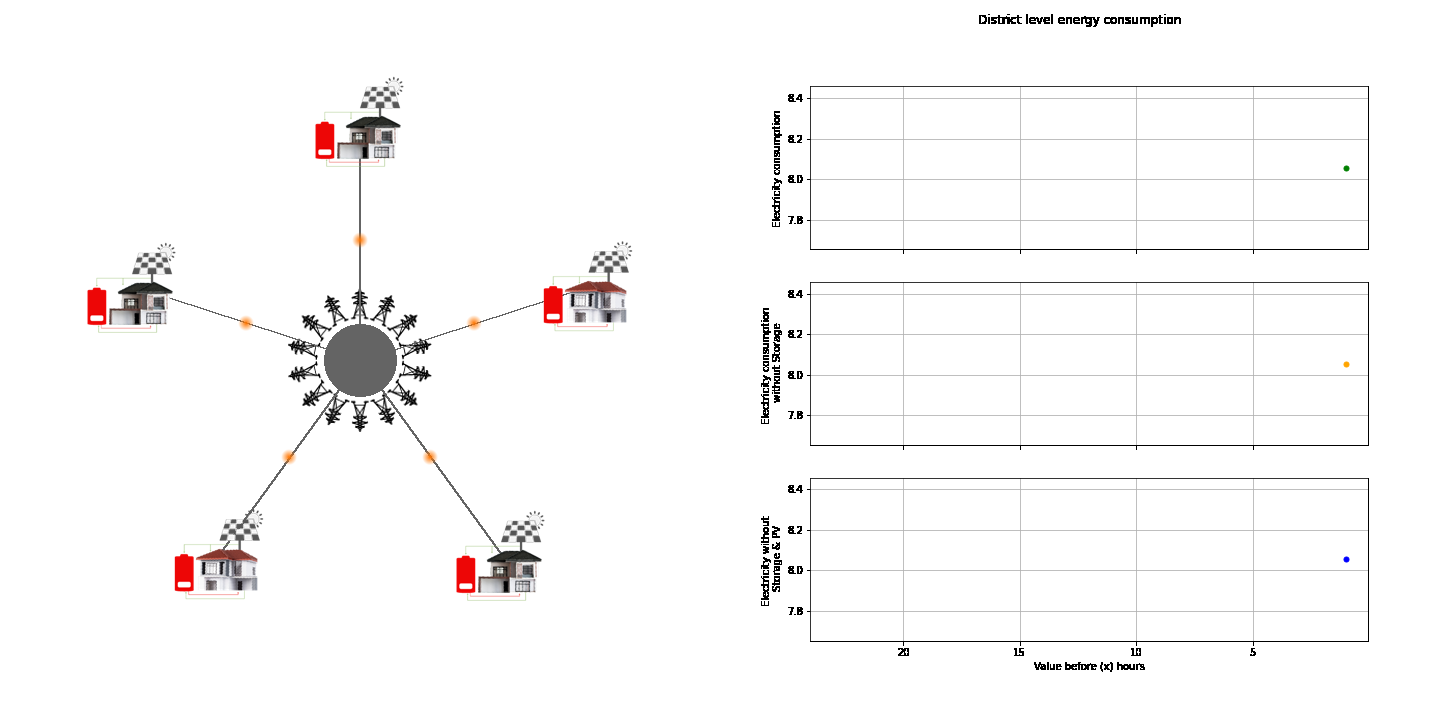

In [5]:
env.reset()
img = env.render()
IPython.display.display(PIL.Image.fromarray(img))

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
# fig.show()
fig.canvas.draw()
background = fig.canvas.copy_from_bbox(ax.bbox)

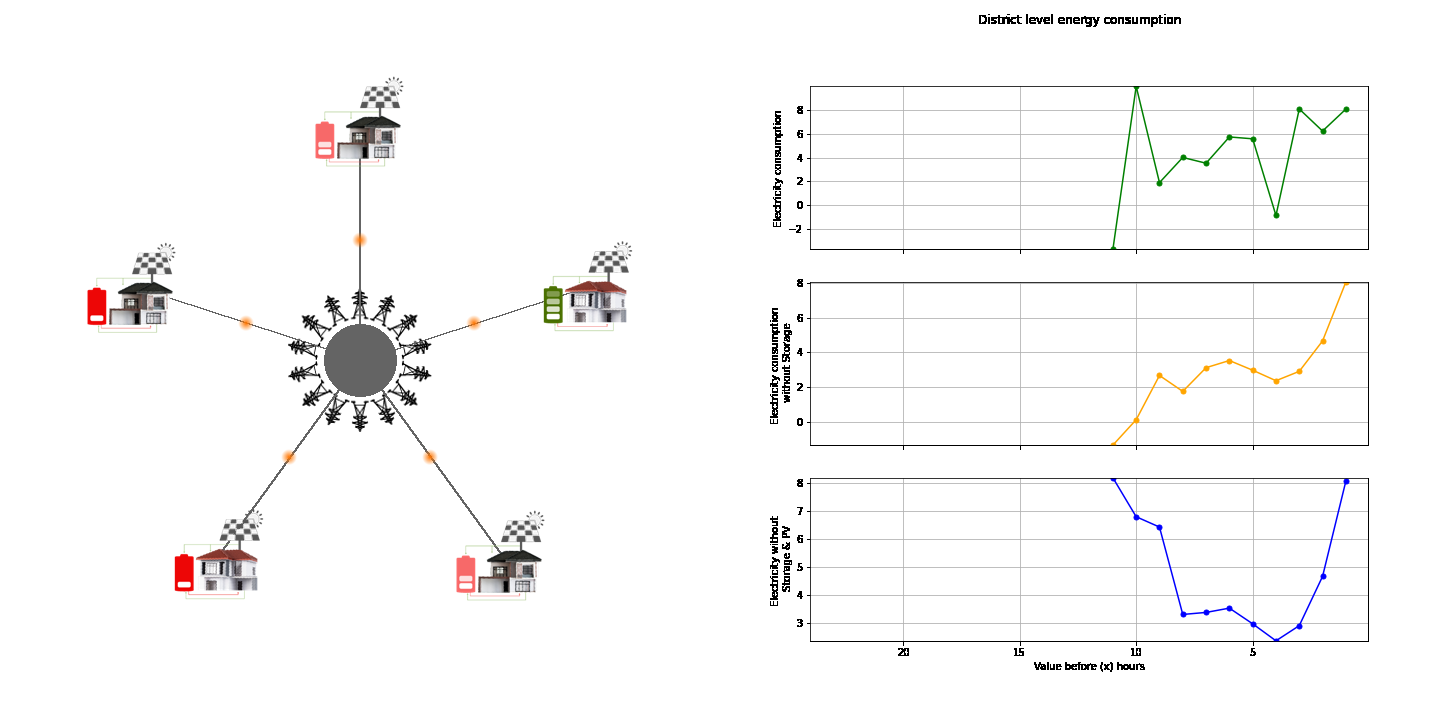

In [60]:
done = False
obs = env.reset()
# rewards = [[] for _ in range(5)]
steps = 0
imgs = []
while not done and steps < 10:
    actions = [a.sample() for a in env.action_space]

    # apply actions to citylearn_env
    next_observations, rew, done, _ = env.step(actions)
    
#     img = env.render()
#     for i in range(len(rew)):
#         rewards[i].append(rew[i])

    observations = [o for o in next_observations]
    img = env.render()

    steps += 1
#     ax.clear()
#     for i in range(len(rew)):
#         points = ax.plot(range(steps), rewards[i])[0]
#     # restore background
#     fig.canvas.restore_region(background)

#     # redraw just the points
#     ax.draw_artist(points)

#     # fill in the axes rectangle
#     fig.canvas.blit(ax.bbox)

#     IPython.display.display(PIL.Image.fromarray(img))
IPython.display.display(PIL.Image.fromarray(img))

## 2. Get Building Information

Building Information is needed as input in the MARLISA algorithm. Building information contains information like 
- A bildings solar power storage capacity
- A buildings annual demand for cooling, heating  and dhw (deep hot water)
- And other information

To get building information, you can run the command `env.get_building_information()`. The information we get does not contain keys like Building_1 which as needed but rather some sequence of random letters and numbers. We make modifications to rename the buildings in the order they appear (I am not sure this renaming is proper and if you have an idea please leave a comment below).

The Buildings are renamed the same way buildings are named in the CityLearn environment.

In [23]:
building_info = env.get_building_information()
building_info

({'solar_power': 4.0,
  'annual_dhw_demand': 0.0,
  'annual_cooling_demand': 0.0,
  'annual_heating_demand': 0.0,
  'annual_nonshiftable_electrical_demand': 10583.353,
  'dhw_storage_capacity': 1e-05,
  'cooling_storage_capacity': 1e-05,
  'heating_storage_capacity': 1e-05,
  'electrical_storage_capacity': 6.399961349767244,
  'correlations_dhw': (nan, nan, nan, nan, nan),
  'correlations_cooling_demand': (nan, nan, nan, nan, nan),
  'correlations_heating_demand': (nan, nan, nan, nan, nan),
  'correlations_non_shiftable_load': (1.0, 0.196, 0.192, 0.166, 0.25)},
 {'solar_power': 4.0,
  'annual_dhw_demand': 0.0,
  'annual_cooling_demand': 0.0,
  'annual_heating_demand': 0.0,
  'annual_nonshiftable_electrical_demand': 9353.601,
  'dhw_storage_capacity': 1e-05,
  'cooling_storage_capacity': 1e-05,
  'heating_storage_capacity': 1e-05,
  'electrical_storage_capacity': 6.399893938684853,
  'correlations_dhw': (nan, nan, nan, nan, nan),
  'correlations_cooling_demand': (nan, nan, nan, nan, nan

In [24]:
observations_spaces, actions_spaces = env.observation_space, env.action_space

building_info = env.get_building_information()

def RenameBuilding(Building_Info):
    newB = {}
    for i, building in enumerate(Building_Info):
        newB["Building_"+str(i+1)] = building_info[i]
    return newB

building_info = RenameBuilding(building_info)
building_info['Building_1']

{'solar_power': 4.0,
 'annual_dhw_demand': 0.0,
 'annual_cooling_demand': 0.0,
 'annual_heating_demand': 0.0,
 'annual_nonshiftable_electrical_demand': 10583.353,
 'dhw_storage_capacity': 1e-05,
 'cooling_storage_capacity': 1e-05,
 'heating_storage_capacity': 1e-05,
 'electrical_storage_capacity': 6.399961349767244,
 'correlations_dhw': (nan, nan, nan, nan, nan),
 'correlations_cooling_demand': (nan, nan, nan, nan, nan),
 'correlations_heating_demand': (nan, nan, nan, nan, nan),
 'correlations_non_shiftable_load': (1.0, 0.196, 0.192, 0.166, 0.25)}

In [33]:
!pip3 install nbformat

     ---------------------------------------- 77.4/77.4 KB 4.2 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\srava\synaptik\SynaptikApp\env\Scripts\python.exe -m pip install --upgrade pip' command.


## 3. A Look at Building Data
Taking a Look at Building Data we see that the observations

- Indoor Temperature [C], Average Unmet Cooling Setpoint Difference [C] and Indoor Relative Humidity [%]: All have NaN values
- DHW Heating [kWh], Cooling Load [kWh] and Heating Load [kWh]: All have values 0

If this is the case when sampled in the environmet, we don't need this variables for learning a model as they don't provide any information about a building or state.

This is useful because inside MARLISA we can set which observations to be removed if need be

In [36]:
import nbformat

In [37]:
nbformat.__version__

'5.8.0'

In [38]:
import pandas as pd
import plotly.express as px

data = pd.read_csv('../env/Lib/site-packages/citylearn/data/citylearn_challenge_2022_phase_1/Building_1.csv')
Missing = data.isnull().sum()

long_df = px.data.medals_long()
 
fig = px.bar(x = Missing.index, y = Missing.values,
             color = Missing.index, title = "Count of Missing Data")
# fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [39]:
data.describe()

,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh],Heating Load [kWh],Solar Generation [W/kW]
count,8760.000000,8760.000000,8760.000000,8760.0,0.0,0.0,0.0,8760.000000,8760.0,8760.0,8760.0,8760.000000
mean,6.526027,12.500000,3.992466,0.0,NaN,NaN,NaN,1.208145,0.0,0.0,0.0,205.836089
std,3.448048,6.922582,2.003522,0.0,NaN,NaN,NaN,0.968270,0.0,0.0,0.0,290.977786
min,1.000000,1.000000,1.000000,0.0,NaN,NaN,NaN,0.057000,0.0,0.0,0.0,0.000000
25%,4.000000,6.750000,2.000000,0.0,NaN,NaN,NaN,0.570167,0.0,0.0,0.0,0.000000
50%,7.000000,12.500000,4.000000,0.0,NaN,NaN,NaN,0.812079,0.0,0.0,0.0,0.000000
75%,10.000000,18.250000,6.000000,0.0,NaN,NaN,NaN,1.530529,0.0,0.0,0.0,412.108333
max,12.000000,24.000000,7.000000,0.0,NaN,NaN,NaN,7.987483,0.0,0.0,0.0,976.250000


## 4. Generate Building States  Action Requirements 

This is an input to the MARLISA algorithm and is used to determine which states or actions are needed for each building. Unlike in the 2020 MARLISA where a buildings requirements file is nicely provided, the information in the 2022 challenge is in the schema.json file. The Requirements for each building state and action is provided (I assume it is same for all buildings) but we need to  modify it for our inpute to suit the algorithm. 

In the file a state with value True means it's required  for the given building and an action with value True means that action needs to be taken for that building and False otherwise.

We see that only action `electrial storage` is needed.

__NOTE: The order  of  the states is same as the order of the observations i.e if month is first then in observation it's in index 0. e.g Hour comes third which mean it's found in index 2__: 

After generating the file, you can save it in Json format for usage as input or give to your algorithm in the dictionary format. Here we use the later. If you use the later, comment `line [37-38]` where the file is read in.

In [42]:
import json

def GenStateActionFromJson(JsonPath, BuildingCount = 5):

    with open(JsonPath) as json_file:
        buildings_states_actions = json.load(json_file)

    States = buildings_states_actions['observations']
    Actions = buildings_states_actions['actions']

    StateINFo = {}
    ActionINFo = {}
    INFos = {}
    
    for var, ins in States.items():
        #print(var, " <><> ", ins)
        if ins['active']:
            StateINFo[var] = ins['active']
    for act, ins  in Actions.items():
        if ins['active']:
            ActionINFo[act] = ins['active']

    INFos["states"] = StateINFo
    INFos["action"] = ActionINFo

    return {"Building_" + str(key): INFos for key in range(1,BuildingCount+1)}


JsonFile = '../env/Lib/site-packages/citylearn/data/citylearn_challenge_2022_phase_1/schema.json'
BuildingsStatesActions = GenStateActionFromJson(JsonFile, BuildingCount = 5)

BuildingsStatesActions["Building_1"]["action"]

{'electrical_storage': True}

## 5. Internal MARLISA Modification

MARLISA CODE Tips for modification for 2022 challenge

### 5.1. Initialization (__init__ body) 

`[Line 58 to 65]` abstract information to individual buildings

`[Line 75-83]` Energy size coefficient for every building (Not Needed in 2022)

`[Line 86-111]` __Define Encoder__: Set Regression Learner for every building, define Encoding for every observation (think of it as data column) and set target variable to be removed __MODIFY ACCORDING TO THE CURRENT DATASET__

`[Line 131-145]` __Define Regression Encoder__: for transforming states in regression model __MODIFY ACCORDING TO THE CURRENT DATASET__

`[Line 149-164]` __Solar Capacity (remove variables if no solar PV)__: removes solar radiation related variables for houses without PV __COMMENT THIS SECTION__


### 5.2. Select Action (MARLISA method or function)

- Takes as inputs `states` and `deterministic`
    - `states`: the states of the buildings
    - `deterministic`: boolean can be true or false

`**[Line 222-226]` __Initialize coordination variables__: coordination variables are two dimesional for every building. __MODIFY ACCORDING TO THE CURRENT DATASET (in 2022 we are asked to optimize for electricty cost and carbon emission)__
- `Capacity  Dispatched:` This is the toal amont of electricity already dispatched. it is related to the energy size coefficient at every time step
- `**Electrical Demand`: Related to the total electricty demand estimated by a prediction algorithm. __Different in Information Sharing and Non Info Sharing Cases__


AFTER the recommended modifications you can make a trial run as shown next

The __REWARD FUNCTION can also be modified__

## 6. RUN MARLISA 2022

To run Marlisa, we need to give it parameters that influence it's learning 

The MARLISA Algorithm takes inputs that we can be classified into two categories

### 6.1. Environment Parameters

These are parameters specific to the reinforcement learning environment (CityLearn Version). They give information about the simulation envrionment that will be used. details about these environmental variables are explored above, to understanding the [2022 citylearn environment, check this notebook](https://www.aicrowd.com/showcase/baby-steps-5fd2bef3-19a6-4ba6-887a-6bbe957a4e33). A summary explanation can be laid down as follows.

- __'building_ids':__ These are the buildings identities in the environment written in the form `"Building_id"` where id is a building number a building_id can look as follows
    - `["Building_1", "Building_2", ... , "Building_n"]`
- __'buildings_states_actions':__ This is a json file defining the different states and actions possible for a building e.g If a building has a 
    - `states {day :  False,  temp: True}` it means there will be information for temp but not for day
    - `"actions": {"cooling_storage": true, "dhw_storage": true, "electrical_storage": false}`. this means there will be no action required or electric storage is absent in the building
- __'building_info':__ Gives valuable information about a building like
    - `solar_power_capacity (kW)`
    - `Annual_DHW_demand (kWh)`
    - `Annual_cooling_demand (kWh)`
    - `Annual_nonshiftable_electrical_demand (kWh)`
    - `etc`
- __'observation_spaces':__ This is information about the observation space of every building in the environment. 
    - It contains n arrays where n is the number of buildings
    - Each array contains the lower and upper bound for the building observation along with it's dimension and datatype
- __'action_spaces':__ This is information about the actions_spaces of every building in the environment
    - It contains n arrays where n is the number of buildings
    - Each array contains the lower and upper bound for the building action along with it's dimension and datatype


### 6.2. Algorithm Parameters

These are parameters specific to our reinforcement learning algorithm. Details about these parameters can be found in the [paper](https://dl.acm.org/doi/10.1145/3408308.3427604). The settings below  are as provided in the original MARLISA implementation found [here](https://github.com/intelligent-environments-lab/CityLearn/blob/master/examples/example_marlisa.ipynb)

- `hidden_dim`:[256,256], 
- `discount`:0.99, 
- `tau`:5e-3, 
- `lr`:3e-4, 
- `batch_size`:256, 
- `replay_buffer_capacity`:1e5, 
- `regression_buffer_capacity`:3e4, 
- `start_training`:600, # Start updating actor-critic networks
- `exploration_period`:7500, # Just taking random actions
- `start_regression`:500, # Start training the regression model
- `information_sharing`:True, # If True -> set the appropriate 'reward_function_ma' in reward_function.py
- `pca_compression`:.95, 
- `action_scaling_coef`:0.5, # Actions are multiplied by this factor to prevent too aggressive actions
- `reward_scaling`:5., # Rewards are normalized and multiplied by this factor
- `update_per_step`:2, # How many times the actor-critic networks are updated every hourly time-step
- `iterations_as`:2,# Iterations of the iterative action selection (see MARLISA paper for more info)
- `safe_exploration`:True

__NOTE: Set the appropriate number of buildings as the environment. Ensure the BuildingsStatesActions generated have same number of buildings as the given environment__

In [46]:
env.schema

{'type': 'citylearn.agents.sac.SAC',
 'attributes': {'hidden_dimension': [256, 256],
  'discount': 0.99,
  'tau': 0.005,
  'lr': 0.003,
  'batch_size': 256,
  'replay_buffer_capacity': 100000.0,
  'start_training_time_step': 6000,
  'end_exploration_time_step': 7000,
  'deterministic_start_time_step': 26280,
  'action_scaling_coef': 0.5,
  'reward_scaling': 5.0,
  'update_per_time_step': 2}}

In [47]:
env.reward

AttributeError: 'CityLearnEnv' object has no attribute 'reward'

In [57]:
schem = env.schema
agent_attributes = schem['agent'].get('attributes', {})

params_agent = {'building_ids':["Building_"+str(i) for i in [1,2,3,4,5]],
                 'buildings_states_actions':BuildingsStatesActions, 
                 'building_info':building_info,
                 'observation_spaces':observations_spaces, 
                 'action_spaces':actions_spaces, 
                 'hidden_dim':[256,256], 
                 'discount':1/12, 
                 'tau':5e-3, 
                 'lr':3e-4, 
                 'batch_size':256, 
                 'replay_buffer_capacity':1e5, 
                 'regression_buffer_capacity':3e4, 
                 'start_training':600, # Start updating actor-critic networks
                 'exploration_period':7500, # Just taking random actions
                 'start_regression':500, # Start training the regression model
                 'information_sharing':True, # If True -> set the appropriate 'reward_function_ma' in reward_function.py
                 'pca_compression':.95, 
                 'action_scaling_coef':0.5, # Actions are multiplied by this factor to prevent too aggressive actions
                 'reward_scaling':5., # Rewards are normalized and multiplied by this factor
                 'update_per_step':2, # How many times the actor-critic networks are updated every hourly time-step
                 'iterations_as':2,# Iterations of the iterative action selection (see MARLISA paper for more info)
                 'safe_exploration':True} 


agent_attributes = {
    'building_ids': [b.uid for b in env.buildings],
    'action_space': env.action_space,
    'observation_space': env.observation_space,
    'building_information': env.get_building_information(),
    'observation_names': env.observation_names,
    **params_agent}
# Instantiating the control agent(s)
agents = MARLISA(**agent_attributes)

RUNTIME = 30*24
shortcut = True
cutshort = True
# We will use 1 episode if we intend to simulate a real-time RL controller (like in the CityLearn Challenge)
# In climate zone 5, 1 episode contains 5 years of data, or 8760*5 time-steps.
n_episodes = 1
start = time.time()
for e in tqdm(range(n_episodes)): 
    state = env.reset()
    done = False
    agents.reset()
    
    j = 0
    is_evaluating = False
    action = agents.select_actions(state)

    while (not done) and shortcut:
        next_state, reward, done, _ = env.step(action)
        action_next = agents.select_actions(next_state)
#         agents.add_to_buffer(state, action, reward, next_state, done)
#         coordination_vars = coordination_vars_next
        state = next_state
        action = action_next

        if j%(24*30) == 0:
            print(f' We are now in step <><><> {j}, with score >> {env.evaluate()}')
        # if cutshort:
        #     is_evaluating = (j > (3*RUNTIME)/2)
        #     j += 1
        
        is_evaluating = (j > 3*8760)
        j += 1
        
        # if j >= RUNTIME:
        #     shortcut = False
        env.render()
        
    print('Loss -',env.evaluate(), 'Simulation time (min) -',(time.time()-start)/60.0)
    # CPU training for 603mins 

  0%|                                                                                                                                             | 0/1 [00:00<?, ?it/s]

 We are now in step <><><> 0, with score >> (1.3095735328450622, 1.2937250095032307, 0.15677070522739914)
 We are now in step <><><> 720, with score >> (1.148521888823134, 1.3939337005966477, 1.69387657880687)
 We are now in step <><><> 1440, with score >> (1.1548521682275128, 1.434614454316056, 1.7251567378941033)
 We are now in step <><><> 2160, with score >> (1.165241397579319, 1.4808757471684009, 1.7655888703831761)
 We are now in step <><><> 2880, with score >> (1.185910899671535, 1.520509217510215, 1.8093848542911342)
 We are now in step <><><> 3600, with score >> (1.173695464107799, 1.4868664747964901, 1.8079739406778874)
 We are now in step <><><> 4320, with score >> (1.1621341347438996, 1.4487304130382375, 1.819376992968769)
 We are now in step <><><> 5040, with score >> (1.1621334404447243, 1.4529316978010327, 1.8355940550832892)


  0%|                                                                                                                                             | 0/1 [00:07<?, ?it/s]

 We are now in step <><><> 5760, with score >> (1.162648293619446, 1.463723600498372, 1.8135085193238278)


NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

#### HOPE U LIKED THE SONG

Leave a comment for any questions, doubts or corrections
